In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import os 
import h5py
import yaml
import tqdm
from scipy.signal import find_peaks

sys.path.append('../src/')

from f2_cluster_functions import linearizeFP, PVEofPCA, calcSilhScore,calcSilhScoreHierarch, getTopFCatProp, getWF, getFP, getSgram, calcFFT


yamlPath = "/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/yaml/demo_150Hz_v3.yaml" ## good
# yamlPath = "/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/yaml/Geysers_1000.yaml" ## good

In [2]:


####################################################################################
####################################################################################
###
### Load yaml file settings, creat paths, set parameters
###
####################################################################################
####################################################################################



with open(yamlPath) as stream:
    config = yaml.safe_load(stream)
    
path_config = config["paths"]
key = path_config["key"]
print("Project key:", key)

projectPath = path_config["projectPath"]

dataH5_name = f'data_{key}.h5'  
dataH5_path = projectPath + 'data/H5files/' + dataH5_name

SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'data/H5files/' + SpecUFEx_H5_name

pathFig = projectPath + 'reports/figures/'
if not os.path.isdir(pathFig):
    os.mkdir(pathFig)
    


#Clustering parameters
cluster_config = config['clusterParams']
clusterOn = cluster_config['clusterOn']               
PVE = cluster_config['PVE']               
method = cluster_config['method']
minK = cluster_config['minK']
maxK = cluster_config['maxK']        
numEx = cluster_config['numEx']       
standardScaler = cluster_config['standardScaler']

Project key: demo_150Hz_v3


In [3]:
####################################################################################
####################################################################################
###
### Import fingerprints event ids, load and linearize FPs 
###
####################################################################################
####################################################################################

ev_IDs = []

with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    for evID in fileLoad['fingerprints']:
        ev_IDs.append(evID)

        



X = linearizeFP(SpecUFEx_H5_path,ev_IDs) #event IDs needed to get fp from H5



col_names = ['fp' + str(a) for a in range(X.shape[1])]
col_names[-1]

fp_df = pd.DataFrame(X,columns=col_names)
fp_df['ev_ID'] = [str(ev) for ev in ev_IDs]
fp_df['event_ID'] = [str(ev) for ev in ev_IDs]

N = len(fp_df)

print(X.shape)
        

(1496, 225)


In [4]:


####################################################################################
####################################################################################
###
### Perform PCA, create df of PCs up to selected PVE
###
####################################################################################
####################################################################################


PCA_df, numPCA, cum_pve = PVEofPCA(X,cum_pve_thresh=PVE,stand=standardScaler)
XPCA = np.array(PCA_df)


1 0.304490342164
2 0.55978961041
3 0.769825293464
4 0.841051133266
5 0.879263754797
break


In [7]:
####################################################################################
####################################################################################
###
### Clustering: Kmeans or Hierarchical
###
####################################################################################
####################################################################################

range_n_clusters = np.arange(minK,maxK+1)
# range_n_clusters = [6]
print(method)
if method=='kmeans':
    


    Kopt, maxSilScore, avgSils, __, cluster_labels_best, ss_best, __ = calcSilhScore(XPCA,range_n_clusters)

    
    
elif method=='hierarchical':
    

    Kopt, maxSilScore, avgSils, cluster_labels_best, ss_best = calcSilhScoreHierarch(XPCA,range_n_clusters)
    
else:
    
    print('Choose "kmeans" or "hierarchical"')
    
    
# Attach cluster labels to dataframes    
PCA_df['Cluster'] = cluster_labels_best
PCA_df['SS'] = ss_best



kmeans
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 6


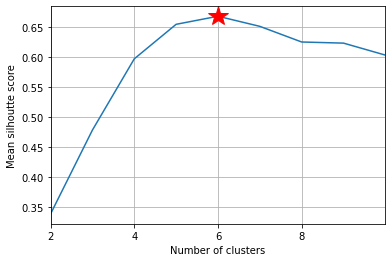

In [8]:
axSS = plt.gca()
axSS.plot(range_n_clusters,avgSils)
axSS.plot(Kopt,avgSils[Kopt-2],'r*',ms=20)
axSS.set_xlabel('Number of clusters')
axSS.set_ylabel('Mean silhoutte score')
axSS.set_xticks(range(min(range_n_clusters),max(range_n_clusters),2));

# axSS.set_ylim(.1,.4)
axSS.set_xlim(min(range_n_clusters),max(range_n_clusters))

axSS.grid()
    
plt.savefig('../reports/figures/FigN_SS.png',dpi=300, bbox_inches='tight')


In [9]:
####################################################################################
####################################################################################
###
### Figure 1. Clustering metrics
###
####################################################################################
####################################################################################

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(range_n_clusters,avgSils)
ax.set_xlabel('N clusters')
ax.set_ylabel('Avg Silh Score')
ax.set_xticks(range_n_clusters);
ax.grid()



plt.savefig(pathFig + key + "SilhScore_clusOnFP.png")

plt.close()


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6


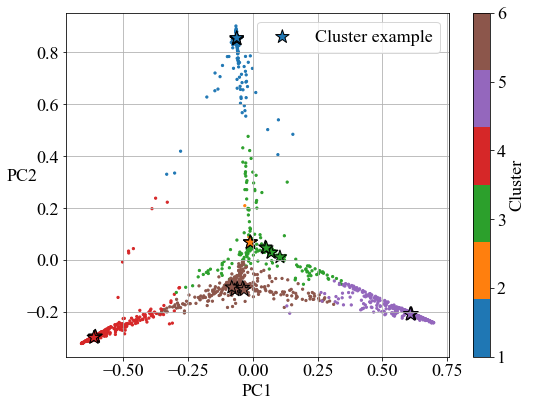

In [10]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})

width = 3.38583

####################################################################################
####################################################################################
###
### Figure 2. PCA colored by cluster assignment
###
####################################################################################
####################################################################################

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(8,6))
ax = plt.gca()

## Make cluster colormap
cluster_colors = [plt.cm.tab20(i) for i in range(0,Kopt)]
if Kopt <= 10:
    cluster_colors = [plt.cm.tab10(i) for i in range(0,Kopt)]
cmap = ListedColormap(cluster_colors)




topF_df_PCA_list = [] 

for cl in range(1,Kopt+1):
    
    PCA_df_k = PCA_df[PCA_df.Cluster==cl].copy()
    PCA_df_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    topF_df_PCA_list.append(PCA_df_k.iloc[0:numEx])
    
    
topF_df_PCA_list_df = pd.concat(topF_df_PCA_list)    


im = ax.scatter(PCA_df.PC1,PCA_df.PC2,c=PCA_df.Cluster,alpha=1,cmap=cmap,s=5)
ax.scatter(topF_df_PCA_list_df.PC1,topF_df_PCA_list_df.PC2,marker='*',
           c=topF_df_PCA_list_df.Cluster,s=200,cmap=cmap,edgecolor='k',
           label='Cluster example')

plt.colorbar(im, ticks=range(1,Kopt+1),label='Cluster',ax=ax)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2",rotation=0)
ax.axis('equal')
ax.grid()
ax.legend();

plt.tight_layout()
plt.savefig(pathFig + "2_" + key + "PCACluster_clusOnFP.png", bbox_to_inches='tight',dpi=300)
# plt.close()

In [11]:
####################################################################################
####################################################################################
###
### Plot dendrogram if using HC
###
####################################################################################
####################################################################################

    
if method=='hierarchical':

    from scipy.cluster.hierarchy import dendrogram
    from scipy.cluster import hierarchy

    ####################################################################################
    ####################################################################################
    ###
    ### Calculate distance and cluster for 20 clusters
    ###
    ####################################################################################
    ####################################################################################

    Kopt, maxSilScore, avgSils, cluster_labels_best, ss_best = calcSilhScoreHierarch(XPCA,[20])


    # Attach cluster labels to dataframes    
    PCA_df['Cluster_20'] = cluster_labels_best


    ####################################################################################
    ####################################################################################
    ###
    ### Figure 2b. Dendrogram (if hierarchcial clustering) 
    ###
    ####################################################################################
    ####################################################################################

    plt.figure(figsize=(10,6))
    ax = plt.gca()
    linked = hierarchy.linkage(XPCA, 'ward')



    ax.set_ylabel('Distance')#, fontsize=16)

    R = dendrogram(
                    linked,
                    truncate_mode='lastp',  # show only the last p merged clusters
                    p=20,  # show only the last p merged clusters
                    no_plot=True,
                    )


    labels = []
    lenClust = [len(PCA_df[PCA_df.Cluster_20==cl]) for cl in range(1,Kopt+1)]


    for k in range(Kopt):

        Nint = int(R['ivl'][k][1:-1])


        labels.append('Cl ' + str(np.argwhere(np.array(lenClust)==Nint)[0][0]+1))




    # This version gives you your label AND the count
    temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{} {}".format(*temp[xx])


    dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=20,  # show only the last p merged clusters
                leaf_label_func=llf,
                leaf_rotation=60.,
                leaf_font_size=16,
                show_contracted=False,
                color_threshold=1,
                above_threshold_color='k',  # to get a distribution impression in truncated branches
                ax=ax
                )


    # axD.set_title('Hierarichal clustering')

    xlbls = ax.get_xmajorticklabels()

    
    ## you can manually set the order of clusters from left to right in the dendrogram
    ## then color the labels by cluster assignment

    
    # order_cl = [4,5,3,2,7,6,1]
    # for num,lbl in zip(order_cl,xlbls):

    #     val=cluster_colors_str[num-1]
    #     lbl.set_color(val)
    # #     lbl.set_fontsize(20)    

plt.tight_layout()
plt.savefig(pathFig + "2b_" +key + "_HC_20clusters_clusOnFP.png", bbox_to_inches='tight',dpi=300)


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6


<Figure size 432x288 with 0 Axes>

In [28]:
Kopt

6

100%|██████████| 5/5 [00:00<00:00, 10.26it/s]
/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6


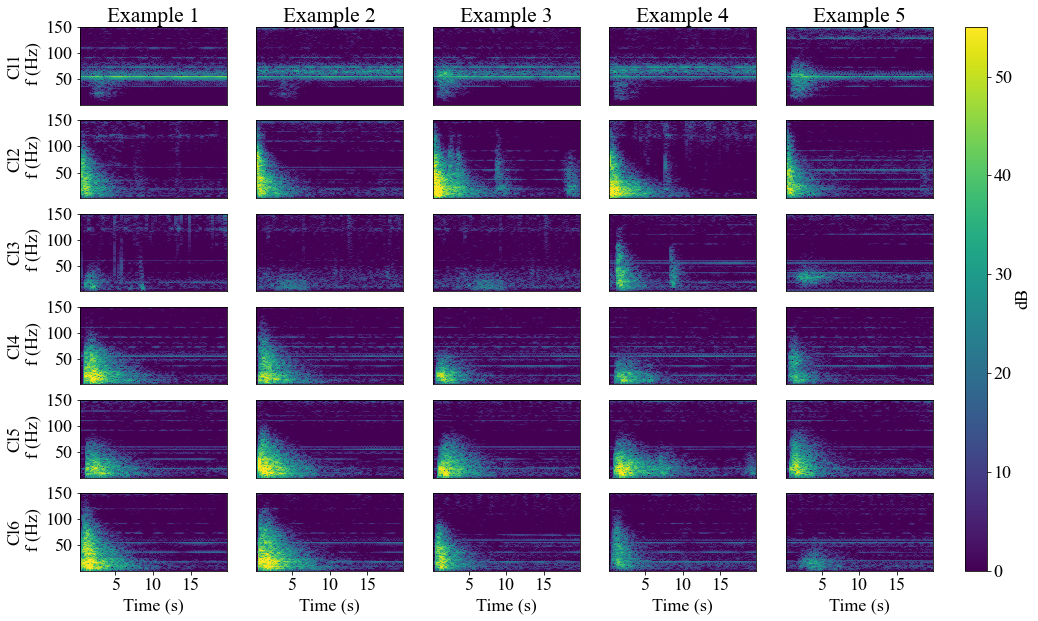

In [41]:
####################################################################################
####################################################################################
###
### Figure 3. Plot spectrogram examples
###
####################################################################################
####################################################################################

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15,10))

gs = GridSpec(nrows=Kopt, ncols=numEx, left=0.1, right=0.89)#, width_ratios=[1, 2], height_ratios=[4, 1])
gs2 = GridSpec(nrows=1, ncols=1, left=0.92, right=.94, hspace=0.05)#, width_ratios=[1, 2], height_ratios=[4, 1])


## get sgram freqs and time vectors
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    
    frequencies = fileLoad['fSTFT'].get('fSTFT')[()]
    times =       fileLoad['tSTFT'].get('tSTFT')[()]

    
    
for cl in range(1,Kopt+1):
    
    PCA_df_k = PCA_df[PCA_df.Cluster==cl].copy()
    PCA_df_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    for i in tqdm.tqdm(range(numEx)):
        
#         ax = axes[cl-1][i]
        ax = fig.add_subplot(gs[cl-1,i])
        
        indd = PCA_df_k.index[i]
        
        tSTFT, fSTFT, sgram = getSgram(ev_IDs[indd], SpecUFEx_H5_path)
        im = ax.pcolormesh(tSTFT,
                            fSTFT,
                            sgram,
                            cmap=plt.cm.viridis,
                            shading='auto',vmin=0,vmax=55)

           
            
#         if i==numEx//2:
        ax.set_xlabel('Time (s)')
            
        if i ==0:
            ax.set_ylabel('Cl' + str(cl) + '\n f (Hz)') 
            
        if cl!=Kopt:
            ax.set_xlabel('')
            ax.set_xticklabels([])           
            ax.set_xticks([])        
        
        if i!=0:
            ax.set_yticks([])
            ax.set_yticklabels([])


            
        if cl==1:    
            ax.set_title('Example ' + str(i+1),pad=5)#,fontsize=12)     

    

axcbar = fig.add_subplot(gs2[:])
cbar = plt.colorbar(im, cax=axcbar,label='dB')




plt.savefig(pathFig + "3_" +key + "_ClusterExamples_clusOnFP.png", bbox_to_inches='tight',dpi=300)
# plt.close()


# Figure   Cluster temporal distribution heatmap

In [11]:
####################################################################################
####################################################################################
###
### Attach datetimes, get hod etc
###
####################################################################################
####################################################################################

binSize = 'M'

PCA_df['event_ID'] = ev_IDs
datetime_format = "%Y.%j.%H%M%S"
datetime = [pd.to_datetime(ds[14:], format=datetime_format) for ds in PCA_df['event_ID']]
# datetime = [pd.to_datetime(ds[14:-9], format=datetime_format) for ds in PCA_df['event_ID']]

PCA_df['datetime'] = datetime
PCA_df['datetime_index'] = datetime
PCA_df_dt = PCA_df.set_index('datetime_index')

PCA_df_dt['hod'] = [dt.hour for dt in PCA_df_dt['datetime']] 


Converted date with fractional time: 1999-01-28 17:40:20.640001


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:198: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6


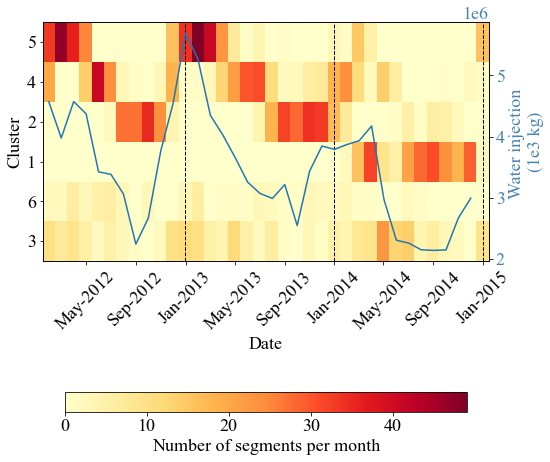

In [12]:
from matplotlib.dates import DateFormatter

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({'font.size': 18})

#####################################################################################
####################################################################################
###
### Format injection data
###
####################################################################################
####################################################################################

def YearFracToTimestamp(frac_year):
    
    year = int(frac_year)
    # Determine if the year is a leap year
    is_leap_year = pd.Timestamp(year, 12, 31).is_leap_year

    # Calculate the total number of days in the year
    total_days_in_year = 366 if is_leap_year else 365

    # Calculate the total fractional day
    total_fractional_day = (frac_year - year) * total_days_in_year

    # Extract the day of the year and the fractional part of the day
    day_of_year = int(total_fractional_day)
    fractional_part_of_day = total_fractional_day - day_of_year

    # Convert the day of the year and fractional part to a pandas Timestamp
    date_with_frac_time = pd.Timestamp(year, 1, 1) + pd.DateOffset(days=day_of_year, hours=24*fractional_part_of_day)

    return date_with_frac_time

# Example usage
fractional_year = 1999.07599  # Example fractional year (representing 75% of the year)
result_timestamp = YearFracToTimestamp(fractional_year)
print("Converted date with fractional time:", result_timestamp)


inj_df = pd.read_pickle('/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/raw/WholeG_inj_data.pkl')

inj_df_trim = inj_df[inj_df.YearFrac>2012]
inj_df_trim = inj_df_trim[inj_df_trim.YearFrac<2015]

inj_df_trim['datetime'] = [YearFracToTimestamp(yf) for yf in inj_df_trim['YearFrac']]
inj_df_trim['datetime_index'] = [YearFracToTimestamp(yf) for yf in inj_df_trim['YearFrac']]
inj_df_trim.set_index('datetime_index',inplace=True)





####################################################################################
####################################################################################
###
### Make Heatmap
###
####################################################################################
####################################################################################


PCA_list = []
for cl in range(1,Kopt+1):
    df_k = PCA_df_dt[PCA_df_dt.Cluster==cl]
    PCA_list.append(df_k)
    
    
# Create a list of cluster counts for each cluster in PCA_df_list resampled at binSize interval
cluster_counts = [PCA_list[i].resample(binSize).count().Cluster for i in range(Kopt)]



# Create a DataFrame with cluster counts for each cluster
heat_df = pd.DataFrame({f'Cl{i+1}': counts for i, counts in enumerate(cluster_counts)})

heat_df = heat_df.fillna(0)


max_Cl_count = np.max(heat_df,0)
heat_df_norm = heat_df / max_Cl_count 









# ####################################################################################
# ####################################################################################
# ###
# ### Reorder cluster
# ###
# ####################################################################################
# ####################################################################################

peaks_list = []
for cl in range(Kopt):
    heat_df_cl = heat_df.iloc[:,cl]

    peaks, props = find_peaks(heat_df_cl,height=25)
    
    try:
        peaks_list.append(peaks[0])
    except:
        peaks_list.append(999)
    
peaks_df = pd.DataFrame({'peaks':peaks_list,
                         'Cluster':range(1,Kopt+1)})

peaks_df.sort_values(by='peaks',inplace=True,ascending=False)

cluster_reorder = list(peaks_df.Cluster)
# ####################################################################################
# ####################################################################################
# ###
# ### Make Heatmap, reordered
# ###
# ####################################################################################
# ####################################################################################
    
    
# Create a list of cluster counts for each cluster in PCA_df_list resampled at binSize interval
cluster_counts = [PCA_list[i-1].resample(binSize).count().Cluster for i in cluster_reorder]



# Create a DataFrame with cluster counts for each cluster
heat_df_reorder = pd.DataFrame({f'Cl{i}': counts for i, counts in zip(cluster_reorder,cluster_counts)})

heat_df_reorder = heat_df_reorder.fillna(0)


max_Cl_count = np.max(heat_df_reorder,0)
heat_df_norm_reorder = heat_df_reorder / max_Cl_count 




####################################################################################
####################################################################################
###
### Plot Heatmap
###
####################################################################################
####################################################################################
# plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,8))
ax = plt.gca()



im = ax.pcolormesh(heat_df_reorder.index,range(1,Kopt+1),heat_df_reorder.T,cmap='YlOrRd',shading='auto')#,vmax=20)
# im = ax.pcolormesh(heat_df.index,range(1,Kopt+1),heat_df.T,cmap='afmhot_r',shading='auto')#,vmax=20)

ax.set_yticks([r+1  for r in range(Kopt)])
ax.set_yticklabels(cluster_reorder)

plt.colorbar(im, 
             label=f'Number of segments per month', 
             orientation='horizontal', 
             pad=0.3,
            shrink=.9,
             ax=ax)#,extend='max')

###----------------------------------------------
### DATELINES
###----------------------------------------------
start_date = '2012-01-01'
end_date = '2015-01-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='Y')
df = pd.DataFrame({'date': date_range})

[ax.axvline(df.iloc[j],lw=1,color='k',ls='--') for j in range(len(df))]

ax.set_ylabel('Cluster')
ax.set_xlabel('Date')

ax.tick_params(axis='x',rotation=45)


ax.xaxis.set_major_formatter(DateFormatter('%b-%Y'))
ax.tick_params(axis='y', size=3)


axInj = ax.twinx()

axInj.plot(inj_df_trim.index,inj_df_trim.Injection_1e3kg)
axInj.set_ylabel('Water injection \n(1e3 kg)',color='steelblue')
axInj.tick_params(axis='y', labelcolor='steelblue')




plt.savefig(pathFig + "4_" + key + "_heatmap_clusOnFP.png", bbox_to_inches='tight',dpi=300)
